# A Very Simple Neural Network for MNIST Data

Import all necessary modules

In [1]:
import sys
if sys.version_info < (3,6):
    raise Exception('This notebook runs with Python 3.6 and higher!')
import numpy as np
import matplotlib.pyplot as plt
from mnist import read,show

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.regularizers import l2,l1
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.initializers import zeros,glorot_uniform
from keras.backend import one_hot, mean
from keras.callbacks import BaseLogger, Callback

from IPython.display import clear_output

%matplotlib inline
np.random.seed(1)


Using TensorFlow backend.


In [2]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y

def mean_pred(y_true, y_pred):
    return mean(y_pred)

def imgshow(X, Y, index):
    img = X[index].copy().reshape(28,28)
    plt.imshow(img)
    print(f'Classified as {Y[index].nonzero()[0][0]}')
    
class LifePlots(keras.callbacks.Callback):
    def __init__(self, epochs):
        self.epochs = epochs
    
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.logs = []
        self.acc = []
        self.val_acc = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        
        
        if (self.i%10 == 0) or (self.i==self.epochs-1) or (self.i==0):
            clear_output(wait=True)
            plt.rcParams["figure.figsize"] = (20,8)            
            fig = plt.figure()
            ax1 = fig.add_subplot(1,2,1)
            ax1.set_title('Losses')
            ax1.set_xlabel('Epoch')
            ax1.set_xlim([0,self.epochs])
            ax1.set_ylim([0.0,self.losses[0]])
            ax1.plot(self.x, self.losses, label="loss")
            ax1.plot(self.x, self.val_losses, label="validation set loss")
            ax1.legend()

            ax2 = fig.add_subplot(1,2,2)
            ax2.set_title('Accuracy')
            ax2.set_xlabel('Epoch')
            ax2.set_xlim([0,self.epochs])
            ax2.set_ylim([0,1.])
            ax2.plot(self.x, self.acc, label="accuracy")
            ax2.plot(self.x, self.val_acc, label="validation set acc")
            ax2.legend()
            plt.show();
                
            print(f"Acc:    {self.acc[-1]:8.4f} Loss:    {self.losses[-1]:8.4f}")            
            print(f"Dev-Acc:{self.val_acc[-1]:8.4f} Dev-Loss:{self.val_losses[-1]:8.4f}")
        
        
        self.i += 1

callback_plot = None

def init_plot(epochs):
    global callback_plot
    
    callback_plot = LifePlots(epochs)
    return callback_plot
    

Read the data from files and reshape the data for the neural network

In [3]:
Y_train,X_train = read(dataset='training')
Y_test,X_test = read(dataset='testing')

Y_train = convert_to_one_hot(Y_train,10)
Y_test = convert_to_one_hot(Y_test,10)

# Data sizes
N_train = X_train.shape[0]
N_test = X_test.shape[0] // 2 # This is for the later split 

# Picture size
pic_x = X_train.shape[1]
pic_y = X_train.shape[2]
N_pixels = pic_x * pic_y

# Reshape the data
X_train = X_train.reshape([N_train,N_pixels])
X_test = X_test.reshape([X_test.shape[0],N_pixels])

The test set is consisting of two parts. The first half has centered numbers and the second half isn't preprocessed, which is basically a different distribution.

In [4]:
# Split the test into dev and test set
X_dev = X_test[N_test:]
Y_dev = Y_test[N_test:]
X_test = X_test[0:N_test]
Y_test = Y_test[0:N_test]

print(f'X train {X_train.shape}')
print(f'Y train {Y_train.shape}')

print(f'X dev {X_dev.shape}')
print(f'Y dev {Y_dev.shape}')

print(f'X test {X_test.shape}')
print(f'Y test {Y_test.shape}')

X train (60000, 784)
Y train (60000, 10)
X dev (5000, 784)
Y dev (5000, 10)
X test (5000, 784)
Y test (5000, 10)


### Hyperparameters

In [5]:
# These parameters are fitted for GPU. 
lamda  = 0.002
lr     = 0.004
epochs = 600
batch  = 20000
seed   = 234

# This gives the number of nodes for all layers from 1 to N-1. The output layer is not included
layerdata = [12,15,15,15,15,15] 

# Choose the activation function
activation_func = 'relu'

### Model

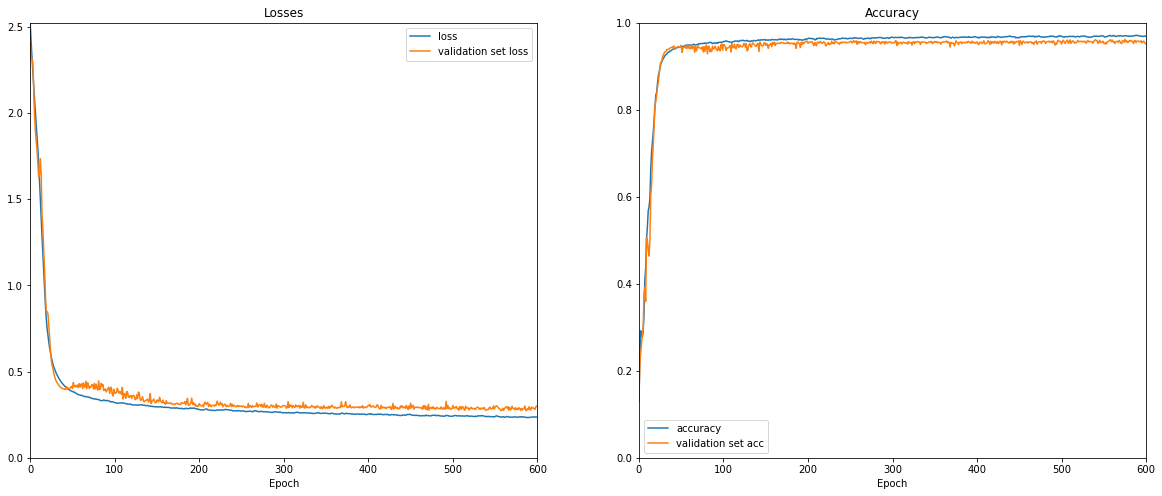

Acc:      0.9695 Loss:      0.2361
Dev-Acc:  0.9520 Dev-Loss:  0.2993


In [6]:
model = Sequential()

# Layer 1
model.add(Dense(units=layerdata[0], 
                input_shape=(N_pixels,),
                kernel_regularizer=l2(lamda),
                #bias_regularizer=l2(lamda),                
                kernel_initializer=glorot_uniform(seed=seed),
                bias_initializer=zeros()))

model.add(BatchNormalization())
model.add(Activation(activation_func))

# Layers from 2 to N-1
for u in layerdata[1:]:
    model.add(Dense(units=u, 
                    kernel_regularizer=l2(lamda),
                    #bias_regularizer=l2(lamda),                
                    kernel_initializer=glorot_uniform(seed=seed),
                    bias_initializer=zeros()))

    model.add(Activation(activation_func))
    
# Output layer
model.add(Dense(
        units=10,
        kernel_regularizer=l2(lamda),
        #bias_regularizer=l2(lamda),                
        kernel_initializer=glorot_uniform(seed=seed),
        bias_initializer=zeros()
        ))

model.add(Activation('softmax'))


# Train the model
model.compile(optimizer=Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

init_plot(epochs)

history = model.fit(X_train, Y_train, 
                    validation_data=[X_dev,Y_dev],
                    epochs=epochs, 
                    batch_size=batch, 
                    callbacks=[callback_plot],
                    verbose=0, 
                    shuffle=True)


### Evaluate the test set

In [7]:
result = model.evaluate(X_test, Y_test, batch_size=batch, verbose=0)
print(f"The accuracy for the test set is {result[1]}")

The accuracy for the test set is 0.9115997552871704


### Check an image

Classified as 6


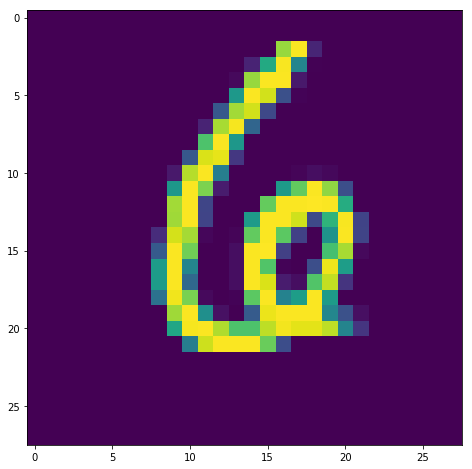

In [8]:
index = 123

imgshow(X_test,Y_test, index)

### Get the prediction

In [10]:
prediction = np.argmax(model.predict(X_test[index].reshape([1,N_pixels])))
print(f'The prediction for this image is {prediction}')

The prediction for this image is 6
